In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from UZ_utils import *
from a2_utils import *
from a3_utils import *
from a4_utils import *
from as3 import *
import os

## Exercise 1: Feature points detectors

### a) The Hessian detector

In [2]:
def hessian_points(I, sigma):

    I_xx, I_xy, I_yy = second_derivative(I, sigma)

    det = I_xx * I_yy - I_xy ** 2
    
    return det / np.max(det)

In [3]:
def new_nonmaxima_suppression_box(I, box_size, thereshold):

    image = np.pad(I, pad_width=box_size//2, mode='constant', constant_values=0)
    result = np.zeros((I.shape))
    rows, cols = image.shape

    for i in range(box_size//2, rows - box_size//2):
        for j in range(box_size//2, cols - box_size//2):

            if image[i, j] > thereshold:
            
                neighbors = image[i - box_size//2:i + box_size//2+1, j - box_size//2:j + box_size//2+1]
                
                if image[i, j] == np.max(neighbors):
                    result[i-box_size//2, j-box_size//2] = image[i, j]
                    
    return result
   

In [4]:
def draw_red_x(image, mask):
    
    plt.imshow(image)
    plt.scatter(np.where(mask > 0)[1], np.where(mask > 0)[0], c='r', marker='x')


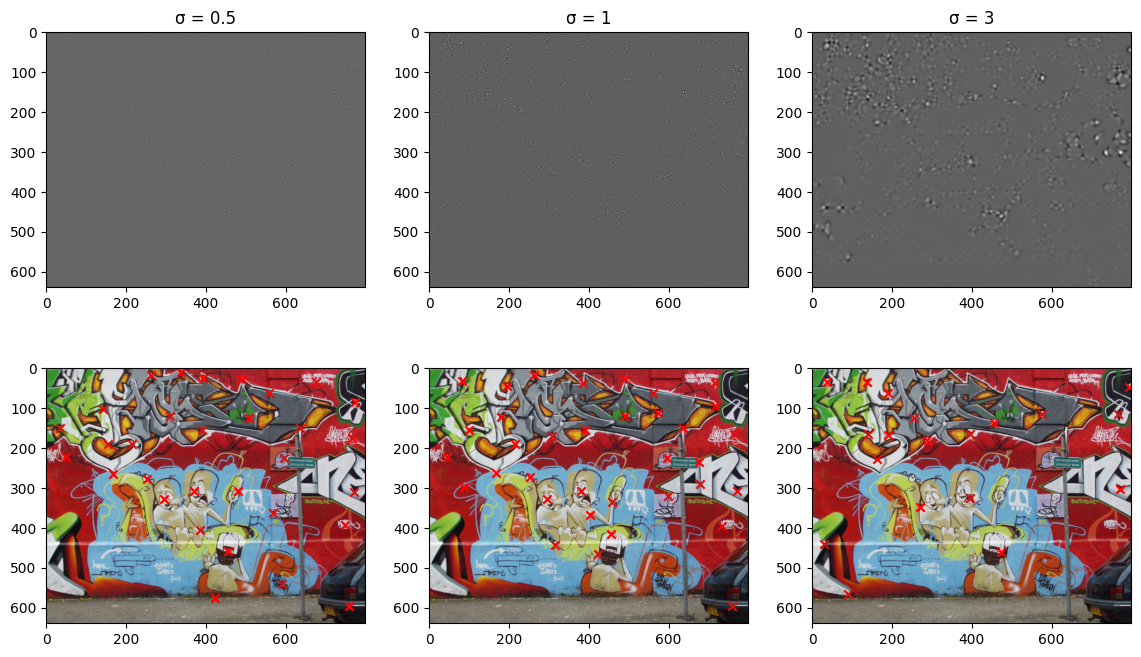

In [5]:

image = cv2.imread("data/graf/graf_a.jpg")  
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
graf_a = imread_gray("data/graf/graf_a.jpg")
det_05 = hessian_points(graf_a, 0.5)
det_1 = hessian_points(graf_a, 1)
det_3 = hessian_points(graf_a, 3)

plt.figure(figsize=(14,8))
plt.subplot(2,3,1)
plt.imshow(det_05, cmap='gray')
plt.title("σ = 0.5")
plt.subplot(2,3,2)
plt.imshow(det_1, cmap='gray')
plt.title("σ = 1")
plt.subplot(2,3,3)
plt.imshow(det_3, cmap='gray')
plt.title("σ = 3")

mask_05 = new_nonmaxima_suppression_box(det_05, 99, 0.35)
mask_1 = new_nonmaxima_suppression_box(det_1, 99, 0.35)
mask_3 = new_nonmaxima_suppression_box(det_3, 99, 0.35)

plt.subplot(2,3,4)
draw_red_x(image, mask_05)
plt.subplot(2,3,5)
draw_red_x(image, mask_1)
plt.subplot(2,3,6)
draw_red_x(image, mask_3)

plt.show()

### b) The Harris feature point detector

In [6]:
def harris_points(I, sigma1, sigma2, alfa):

    I_x, I_y = first_derivative(I, sigma1)

    A = convolve(I_x**2, gauss(sigma2))
    B = convolve(I_y**2, gauss(sigma2))
    C = convolve(I_x * I_y, gauss(sigma2))

    det = A * B - C**2

    trace = A + B

    harris = det - alfa * trace**2

    return harris

    

0.0015708496380486326 0.0010592337988970274 0.0009011282727719948
-0.0009285462319537684 -0.0005982349264520699 -0.0006160427458587376


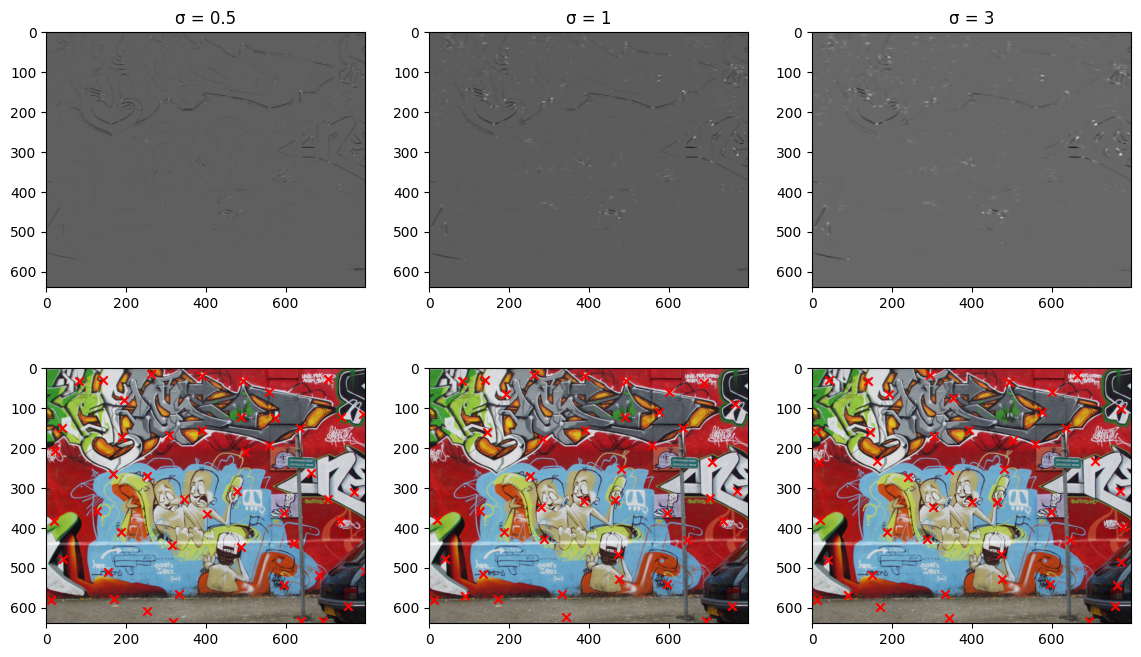

In [7]:
image = cv2.imread("data/graf/graf_a.jpg")  
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
graf_a = imread_gray("data/graf/graf_a.jpg")
det_05 = harris_points(graf_a, 1, 1.6*1, 0.06)
det_1 = harris_points(graf_a, 1.5, 1.6*1.5, 0.04)
det_3 = harris_points(graf_a, 2, 2*1.6, 0.04)

print(np.max(det_05), np.max(det_1), np.max(det_3))
print(np.min(det_05), np.min(det_1), np.min(det_3))

plt.figure(figsize=(14,8))
plt.subplot(2,3,1)
plt.imshow(det_05, cmap='gray')
plt.title("σ = 0.5")
plt.subplot(2,3,2)
plt.imshow(det_1, cmap='gray')
plt.title("σ = 1")
plt.subplot(2,3,3)
plt.imshow(det_3, cmap='gray')
plt.title("σ = 3")

mask_05 = new_nonmaxima_suppression_box(det_05, 99, 0.000001)
mask_1 = new_nonmaxima_suppression_box(det_1, 99, 0.000001)
mask_3 = new_nonmaxima_suppression_box(det_3, 99, 0.000001)

plt.subplot(2,3,4)
draw_red_x(image, mask_05)
plt.subplot(2,3,5)
draw_red_x(image, mask_1)
plt.subplot(2,3,6)
draw_red_x(image, mask_3)

plt.show()

## Exercise 2: Matching local regions

### a) Write a function find_correspondences which calculates similarities between all descriptors in two given lists.

In [8]:
def compare(H1, H2, measure:str):

    distance = 0
    if measure == "L2":
        difference = (H1 - H2) ** 2
        distance = np.sqrt(np.sum(difference))
    elif measure == "X2":
        e = 1e-10
        difference = (H1 - H2) ** 2
        sum = H1 + H2 + e
        distance = 0.5 * np.sum((difference / sum))
    elif measure == "I":
        minimum = np.minimum(H1, H2)
        distance = 1 - np.sum(minimum)
    elif measure == "H":
        sqrt_H1 = np.sqrt(H1)
        sqrt_H2 = np.sqrt(H2)
        difference = (sqrt_H1 - sqrt_H2)**2
        distance = np.sqrt(0.5 * np.sum(difference))
        
    return round(distance,2)

In [9]:
def find_correspondences(descriptors_a, descriptors_b, list_x_a, list_y_a, list_x_b, list_y_b, measure):

    correspondences = np.zeros((descriptors_a.shape[0], descriptors_b.shape[0]))

    for i in range(descriptors_a.shape[0]):
        for j in range(descriptors_b.shape[0]):
            sqrt_a = np.sqrt(descriptors_a[i])
            sqrt_b = np.sqrt(descriptors_b[j])
            difference = (sqrt_a - sqrt_b)**2
            distance = compare(descriptors_a[i], descriptors_b[j], measure)
            correspondences[i, j] = distance

    matches_a = []
    matches_b = []
    indexes = []

    for i in range(descriptors_a.shape[0]):
        
        j = np.argmin(correspondences[i])

        matches_a.append([list_x_a[i], list_y_a[i]])
        matches_b.append([list_x_b[j], list_y_b[j]])
        indexes.append(j)



        
    return matches_a, matches_b, indexes


    

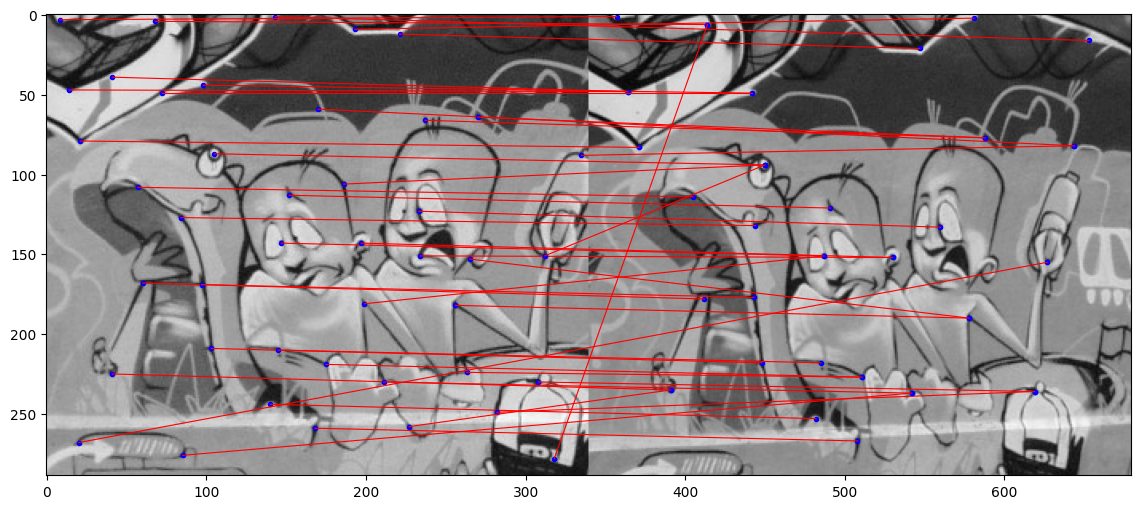

In [10]:
small_a = imread_gray("data/graf/graf_a_small.jpg")  
small_b = imread_gray("data/graf/graf_b_small.jpg")

det_a = hessian_points(small_a, 1)
det_b = hessian_points(small_b, 1)

mask_a = new_nonmaxima_suppression_box(det_a, 49, 0.1)
mask_b = new_nonmaxima_suppression_box(det_b, 49, 0.1)

list_y_a, list_x_a = np.where(mask_a > 0)
list_y_b, list_x_b = np.where(mask_b > 0)


descriptors_a = simple_descriptors(small_a, list_y_a, list_x_a)
descriptors_b = simple_descriptors(small_b, list_y_b, list_x_b)

matches_a, matches_b, indexes = find_correspondences(descriptors_a, descriptors_b, list_x_a, list_y_a, list_x_b, list_y_b, "H")

plt.figure(figsize=(14,8))
display_matches(small_a, matches_a, small_b, matches_b)



### b) Implement a simple feature point matching algorithm. Write a function find_matches.

In [11]:
def find_matches(image_1, image_2, descriptor_function, box_size, thresh, measure):

    det_1 = hessian_points(image_1, 1)  
    det_2 = hessian_points(image_2, 1)

    mask_1 = new_nonmaxima_suppression_box(det_1, box_size, thresh)
    mask_2 = new_nonmaxima_suppression_box(det_2, box_size, thresh)

    list_x_1 = []
    list_y_1 = []
    list_x_2 = []
    list_y_2 = []

    for y in range(image_1.shape[0]):
        for x in range(image_1.shape[1]):
            if mask_1[y, x] > 0:
                list_x_1.append(x)
                list_y_1.append(y)
            if mask_2[y, x] > 0:
                list_x_2.append(x)
                list_y_2.append(y)

    descriptors_1 = descriptor_function(image_1, list_y_1, list_x_1)
    descriptors_2 = descriptor_function(image_2, list_y_2, list_x_2)

    matches_11, matches_12, indexes_1 = find_correspondences(descriptors_1, descriptors_2, list_x_1, list_y_1, list_x_2, list_y_2, measure)
    _, _, indexes_2 = find_correspondences(descriptors_2, descriptors_1, list_x_2, list_y_2, list_x_1, list_y_1, measure)

    matches_1 = []
    matches_2 = []
    indexes = []

    for i in range(len(indexes_1)):

        if i == indexes_2[indexes_1[i]]:

            matches_1.append(matches_11[i])
            matches_2.append(matches_12[i])
            indexes.append((i,indexes_1[i]))


    return matches_1, matches_2, indexes





    


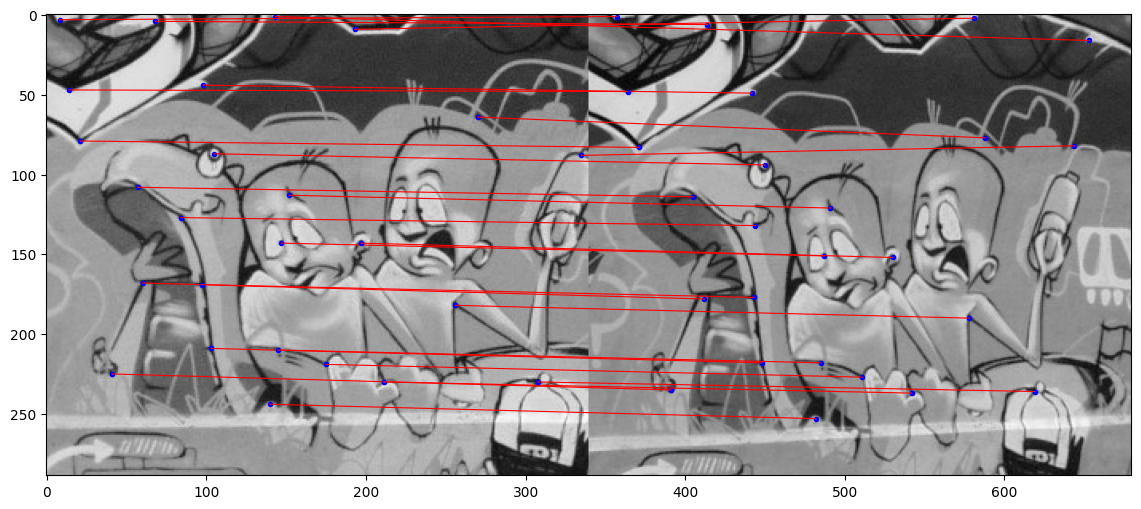

In [13]:
image_1 = imread_gray("data/graf/graf_a_small.jpg")
image_2 = imread_gray("data/graf/graf_b_small.jpg")
matches_1, matches_2, _ = find_matches(image_1, image_2, simple_descriptors, 49, 0.1, "H")

plt.figure(figsize=(14,8))
display_matches(image_1, matches_1, image_2, matches_2)

### c) Implement a local feature descriptor of your choice (e.g. SIFT, SURF, BRIEF, HOG).

In [14]:
def divide_into_grid(image, grid_size):
    
    cells = np.array_split(image, grid_size[0], axis=0)
    cells = [np.array_split(cell, grid_size[1], axis=1) for cell in cells]
    grid_cells = [cell for row in cells for cell in row]

    return grid_cells

In [15]:
def histogram(mags, angs, n_bins):

    height, width = mags.shape
    y_center, x_center = height // 2, width // 2
    y_indices, x_indices = np.indices((height, width))
    gaussian_weights = np.exp(-((x_indices - x_center)**2 + (y_indices - y_center)**2) / (2 * 1**2))

    
    hist = np.zeros(n_bins)
    for m, a, g in zip(mags.reshape(-1), angs.reshape(-1), gaussian_weights.reshape(-1)):
        hist[a] += m*g

    return hist

In [16]:
def feature(image, sigma, n_bins):
    magnitudes, angles = gradient_magnitude(image, sigma)
    angle_values = np.linspace(-np.pi, np.pi, n_bins)
    angles = np.digitize(angles, bins=angle_values) - 1

    mag_cells = divide_into_grid(magnitudes, (4, 4))
    angle_cells = divide_into_grid(angles, (4, 4))

    features = []
    for m, a in zip(mag_cells, angle_cells):
        hist = histogram(m, a, n_bins)
        features.extend(hist)

    return np.array(features)
    

In [17]:
def sift_descriptor(I, Y, X, region_size=16, n_bins = 8, sigma = 1):

    height, width = I.shape

    descriptors = []

    for i in range(len(Y)):

        half_region = region_size // 2
        region = I[max(0, Y[i]-half_region):min(I.shape[0], Y[i]+half_region),
                   max(0, X[i]-half_region):min(I.shape[1], X[i]+half_region)]
        

        f = feature(region, sigma, n_bins)

        descriptors.append(f)

    return np.array(descriptors)


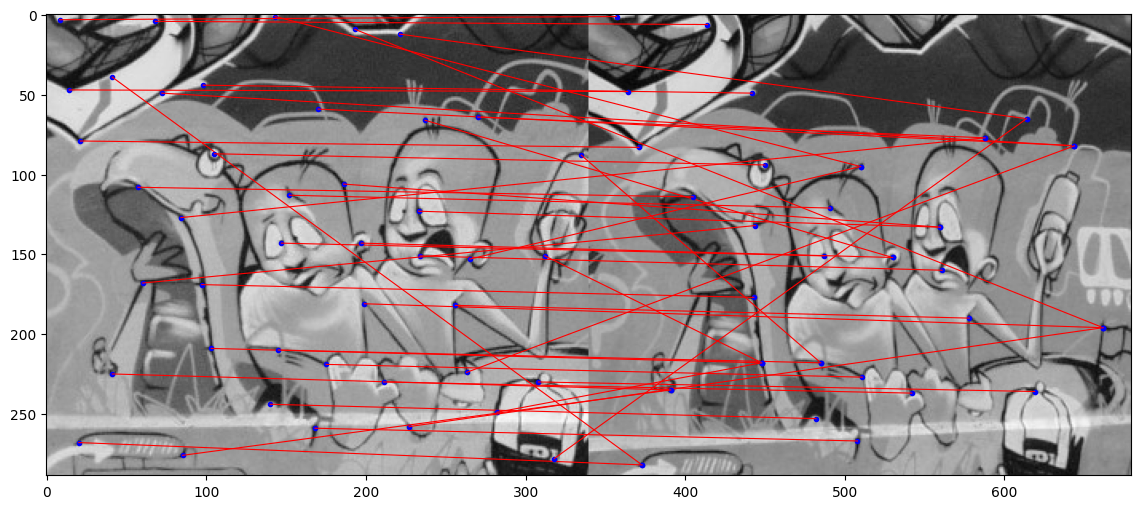

In [18]:
small_a = imread_gray("data/graf/graf_a_small.jpg")  
small_b = imread_gray("data/graf/graf_b_small.jpg")

det_a = hessian_points(small_a, 1)
det_b = hessian_points(small_b, 1)

mask_a = new_nonmaxima_suppression_box(det_a, 49, 0.1)
mask_b = new_nonmaxima_suppression_box(det_b, 49, 0.1)

list_y_a, list_x_a = np.where(mask_a > 0)
list_y_b, list_x_b = np.where(mask_b > 0)

descriptors_a = sift_descriptor(small_a, list_y_a, list_x_a)
descriptors_b = sift_descriptor(small_b, list_y_b, list_x_b)

matches_a, matches_b, indexes = find_correspondences(descriptors_a, descriptors_b, list_x_a, list_y_a, list_x_b, list_y_b, "L2")

plt.figure(figsize=(14,8))
display_matches(small_a, matches_a, small_b, matches_b)

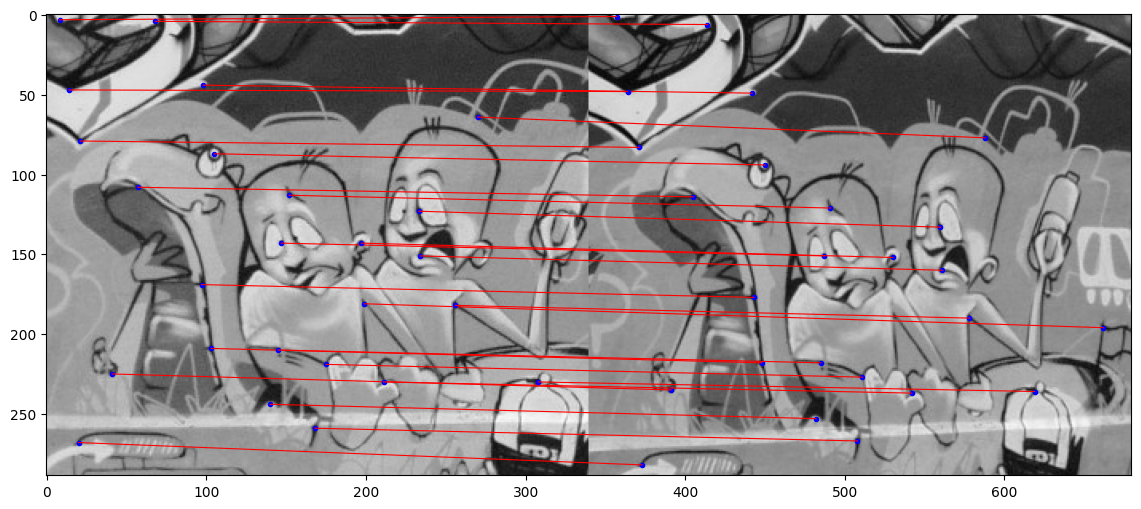

In [19]:
matches_1, matches_2, _ = find_matches(image_1, image_2, sift_descriptor, 49, 0.1, "L2")

plt.figure(figsize=(14,8))
display_matches(image_1, matches_1, image_2, matches_2)

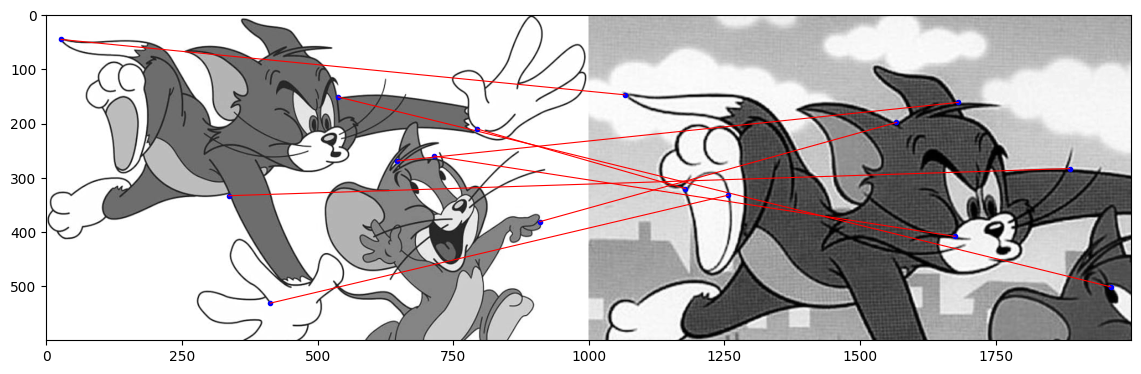

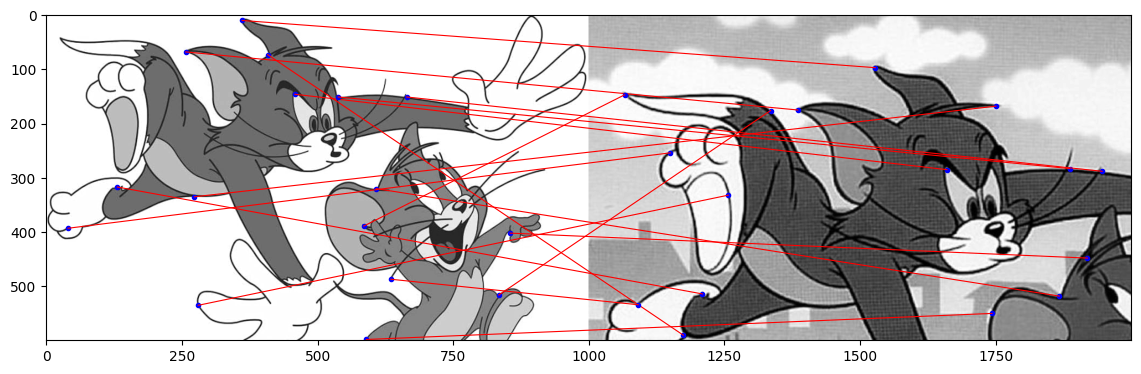

In [20]:
i2 = imread_gray("data/tom2.jpg")[0:600, 0:1000]
i3 = imread_gray("data/tom3.jpg")[0:600, 0:1000]

matches_1, matches_2, _ = find_matches(i2, i3, simple_descriptors, 99, 0.05, "H")
plt.figure(figsize=(14,8))
display_matches(i2, matches_1, i3, matches_2)

matches_1, matches_2, _ = find_matches(i2, i3, sift_descriptor, 99, 0.05, "X2")
plt.figure(figsize=(14,8))
display_matches(i2, matches_1, i3, matches_2)




## Exercise 3: Homography estimation

### a) Write a function estimate_homography, that approximates a homography between two images using a given set of matched feature points.

In [21]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def estimate_homography(points_1, points_2):
    
    A = []
    for i in range(len(points_1)):
        x1, y1 = points_1[i]
        x2, y2 = points_2[i]
        A.append([x1, y1, 1, 0, 0, 0, -x2 * x1, -x2 * y1, -x2])
        A.append([0, 0, 0, x1, y1, 1, -y2 * x1, -y2 * y1, -y2])
    
    A = np.array(A)

    U, S, Vt = np.linalg.svd(A)

    h = Vt[-1, :]
    h = h / h[-1]
    
    H = h.reshape(3, 3)
    
    return H



In [22]:
def load_points(path):
    points_1 = []
    points_2 = []
    data = np.loadtxt(path)

    for i in range(data.shape[0]):
        points_1.append([data[i, 0], data[i, 1]])
        points_2.append([data[i, 2], data[i, 3]])
    
    return points_1, points_2
    

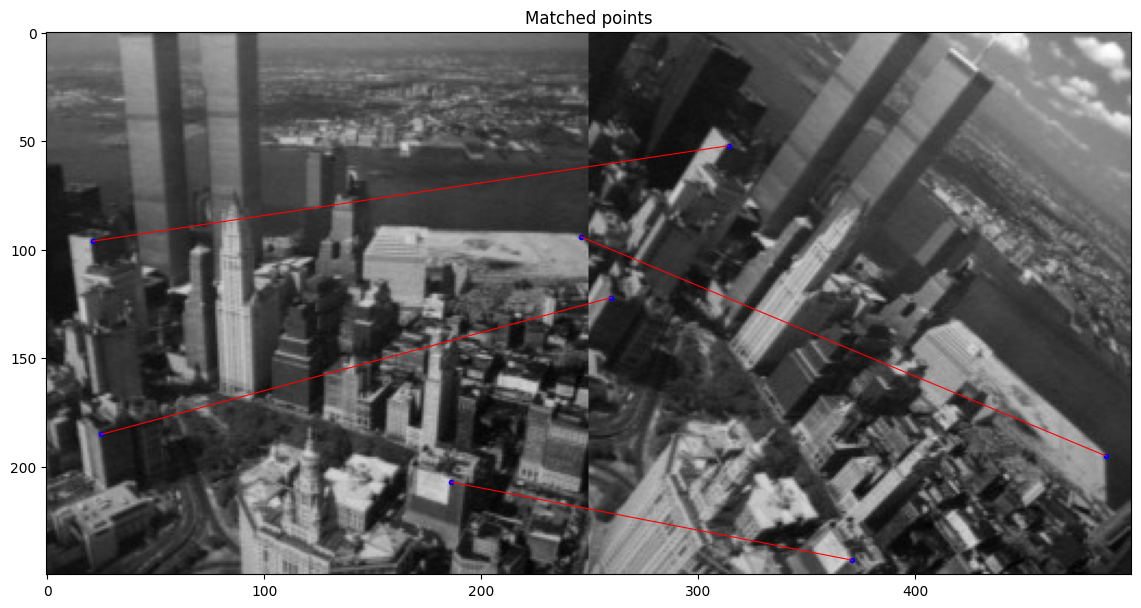

In [23]:
newyork_a = imread_gray("data/newyork/newyork_a.jpg")
newyork_b = imread_gray("data/newyork/newyork_b.jpg")

points_1, points_2 = load_points("data/newyork/newyork.txt")

H = estimate_homography(points_1, points_2)

transformed = cv2.warpPerspective(newyork_a, H, newyork_a.shape)

plt.figure(figsize=(14,8))

plt.title("Matched points")
display_matches(newyork_a, points_1, newyork_b, points_2)

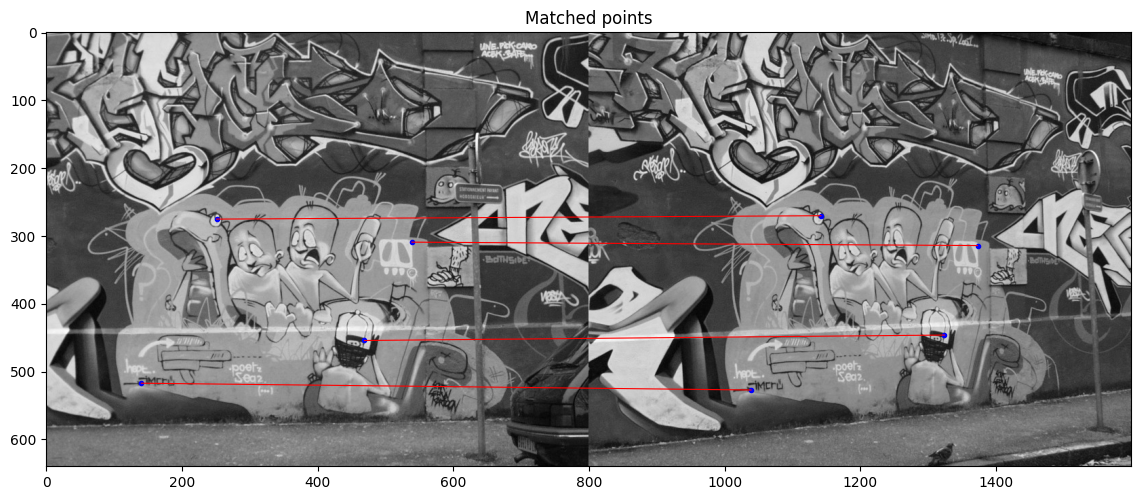

In [24]:
graf_a = imread_gray("data/graf/graf_a.jpg")
graf_b = imread_gray("data/graf/graf_b.jpg")

points_1, points_2 = load_points("data/graf/graf.txt")

H = estimate_homography(points_1, points_2)
transformed = cv2.warpPerspective(graf_a, H, graf_a.shape)
plt.figure(figsize=(14,8))
plt.title("Matched points")
display_matches(graf_a, points_1, graf_b, points_2)

###  b) Implement 2d line fitting with RANSAC.

In [25]:
def calculate_distance(points, line):
    a, b = line
    x, y = points[:, 0], points[:, 1]
    return np.abs(a * x - y + b) / np.sqrt(a**2 + 1)


In [26]:

def line_fitting_ransac(points, iterations, threshold):

    best_line = None
    max_inliers = 0

    rows = (iterations + 4) // 5  
    cols = 5
    fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 3), constrained_layout=True)

    axes = axes.flatten()

    for i in range(iterations):

        sample = points[np.random.choice(points.shape[0], size=2, replace=False)]
        p1, p2 = sample
        a = (p2[1] - p1[1]) / (p2[0] - p1[0])
        b = p1[1] - a * p1[0]
        current_line = (a, b)
        
        distances = calculate_distance(points, current_line)
        inliers = points[distances < threshold]
        
        ax = axes[i]
        ax.scatter(points[:, 0], points[:, 1], c="gray", label="Points")
        ax.scatter(inliers[:, 0], inliers[:, 1], c="blue", label="Inliers")
        ax.plot(x, a * x + b, "r--", label="Current Line")
        if best_line is not None:
            ax.plot(x, best_line[0] * x + best_line[1], "g-", label="Best Line")
        ax.set_title(f"Iteration {i+1}")
        ax.legend()
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)


        if len(inliers) > max_inliers:
            max_inliers = len(inliers)
            best_line = current_line

    for j in range(iterations, len(axes)):
        axes[j].axis("off")

    plt.show()


    



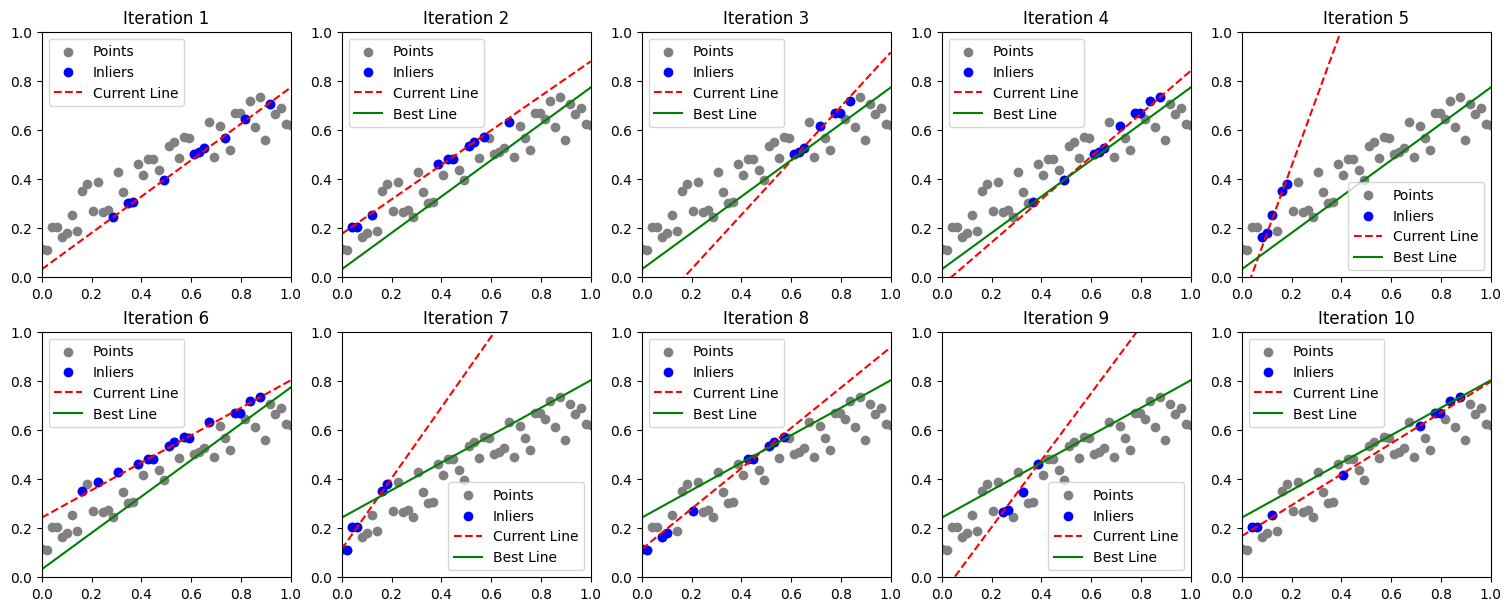

In [27]:

true_slope = 0.5
true_intercept = 0.2
num_points = 50
noise = 0.1

x = np.linspace(0, 1, num_points)
y = true_slope * x + true_intercept + np.random.uniform(-noise, noise, size=num_points)
points = np.column_stack((x, y))

iterations = 10 
threshold = 0.02 

line_fitting_ransac(points, iterations, threshold)

### c) Implement the RANSAC algorithm for robust estimation of the homography matrix. 

In [28]:
def ransac(matches, points_1, points_2, iterations=5000, threshold=10):
    best_H = None
    best_inliers = []
    best_error = float('inf')
    inlier_counts = []
    
    for _ in range(iterations):
        random_matches = random.sample(matches, 4)
        new_points_1 = []
        new_points_2 = []
        for a, b in random_matches:
            new_points_1.append(points_1[a])
            new_points_2.append(points_2[b])
        
        H = estimate_homography(new_points_1, new_points_2)
        
        error = 0
        inliers = []
        
        for a, b in matches:
            x1, y1 = points_1[a]
            x2, y2 = points_2[b]
            
            x1 = np.array([x1, y1, 1])
            x2 = np.array([x2, y2, 1])

            x1_proj = np.dot(H, x1)
            
            distance = np.linalg.norm(x1_proj - x2)
            error += distance
            
            if distance < threshold:
                inliers.append((a, b))
        
        inlier_counts.append(len(inliers))
        
        if len(inliers) > 0:
            error /= len(inliers)
        if error < best_error:
            best_error = error
            best_inliers = inliers
            best_H = H

    average_inliers = np.mean(inlier_counts) / 4

    print(f"Average number of inliers: {average_inliers}")

        
    return best_inliers, best_H

Average number of inliers: 0.87045
0.6842105263157895


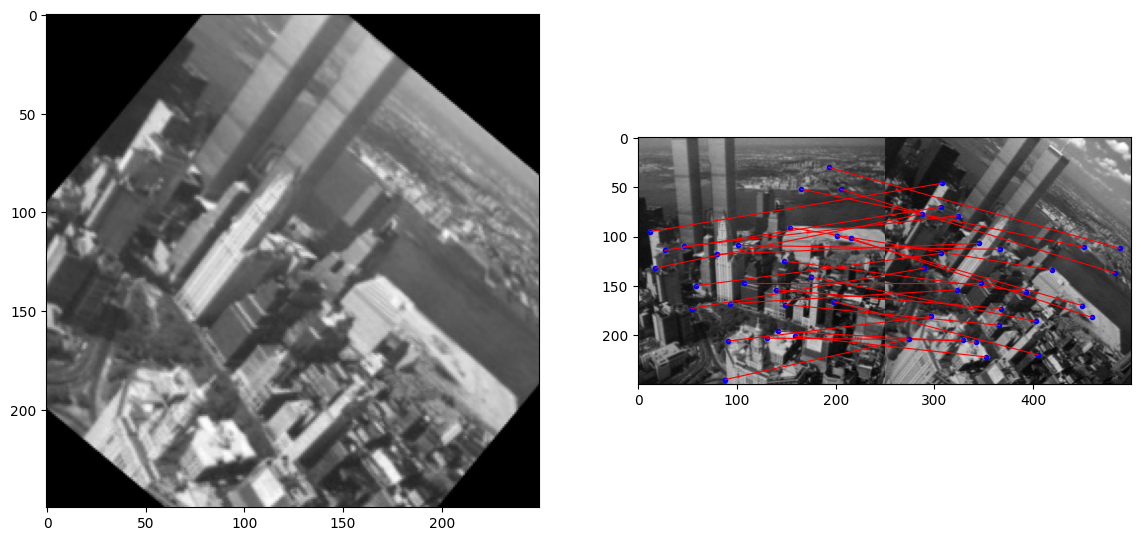

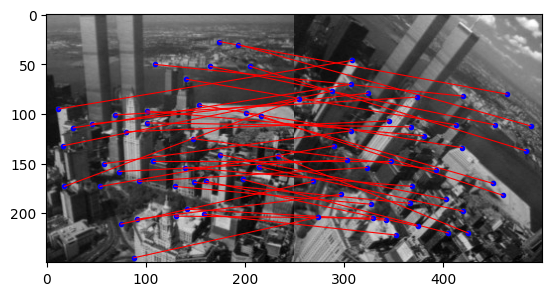

In [29]:
det_a = hessian_points(newyork_a, 1)
det_b = hessian_points(newyork_b, 1)

mask_a = new_nonmaxima_suppression_box(det_a, 21, 0.1)
mask_b = new_nonmaxima_suppression_box(det_b, 21, 0.1)

list_y_a, list_x_a = np.where(mask_a > 0)
list_y_b, list_x_b = np.where(mask_b > 0)

points_a = np.column_stack((list_x_a, list_y_a))
points_b = np.column_stack((list_x_b, list_y_b))


s1, s2, indexes= find_matches(newyork_a, newyork_b, simple_descriptors, 21, 0.1, "H")


best_inliers, best_H = ransac(indexes, points_a, points_b)

print(len(best_inliers)/len(indexes))


best_1 = []
best_2 = []
for a,b in best_inliers:
    best_1.append(points_a[a])
    best_2.append(points_b[b])
new_img = cv2.warpPerspective(newyork_a, best_H, newyork_a.shape)
plt.figure(figsize=(14,8))
plt.subplot(1,2,1)
plt.imshow(new_img, cmap="gray")
plt.subplot(1,2,2)
display_matches(newyork_a, best_1, newyork_b, best_2)
display_matches(newyork_a, s1, newyork_b, s2)



plt.show()
    


###  d) Calculate the number of expected iterations for RANSAC using the formula mentioned in the instructions.

In [30]:
def ransac_early_stop(matches, points_1, points_2, w, iterations=5000, threshold=10):
    best_H = None
    best_inliers = []
    best_error = float('inf')

    
    n = 4 
    p_success = 0.99
    k = int(np.log(1 - p_success) / np.log(1 - w ** n)) 
    print(f"Expected number of iterations: {k}")
    
    for i in range(min(iterations, k)):
        random_matches = random.sample(matches, 4)
        new_points_1 = []
        new_points_2 = []
        for a, b in random_matches:
            new_points_1.append(points_1[a])
            new_points_2.append(points_2[b])
        
        H = estimate_homography(new_points_1, new_points_2)
        
        error = 0
        inliers = []
        
        for a, b in matches:
            x1, y1 = points_1[a]
            x2, y2 = points_2[b]
            
            x1 = np.array([x1, y1, 1])
            x2 = np.array([x2, y2, 1])

            x1_proj = np.dot(H, x1)
            
            distance = np.linalg.norm(x1_proj - x2)
            error += distance
            
            if distance < threshold:
                inliers.append((a, b))
        
        if len(inliers) > 0:
            error /= len(inliers)
        if error < best_error:
            best_error = error
            best_inliers = inliers
            best_H = H

        if(len(best_inliers)/len(matches) > w):
            print("v vaa zastanalo ",i)
            break    
       

        
    return best_inliers, best_H

Expected number of iterations: 71
v vaa zastanalo  24


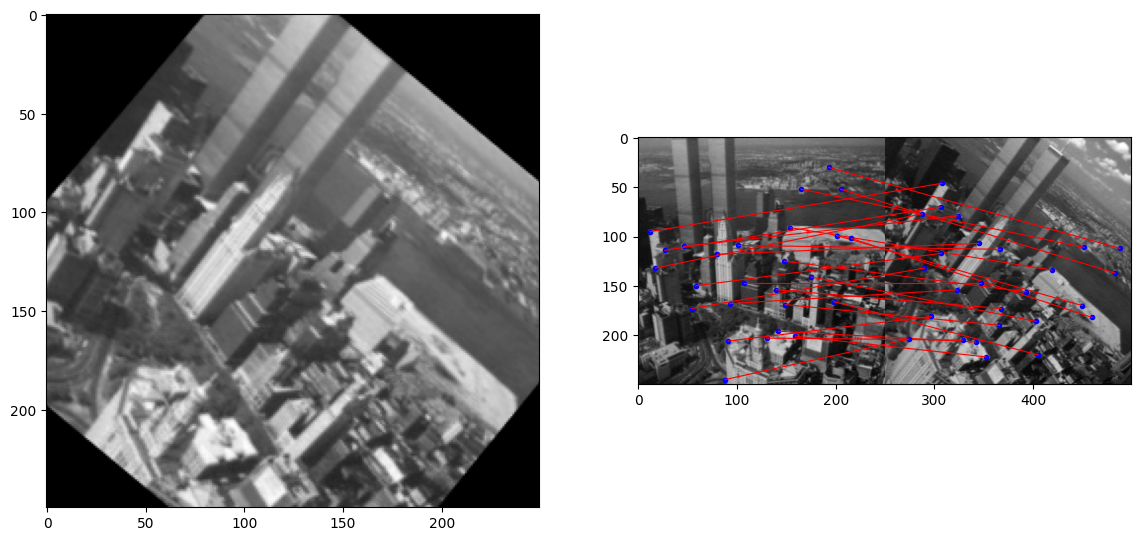

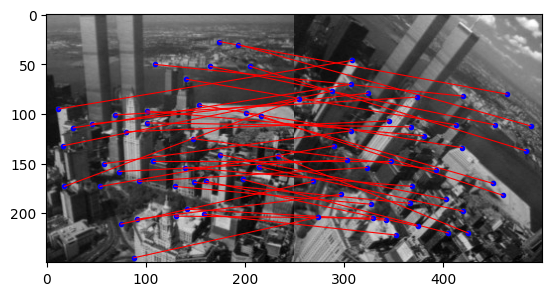

In [31]:
best_inliers, best_H = ransac_early_stop(indexes, points_a, points_b, 0.5)


best_1 = []
best_2 = []
for a,b in best_inliers:
    best_1.append(points_a[a])
    best_2.append(points_b[b])
new_img = cv2.warpPerspective(newyork_a, best_H, newyork_a.shape)
plt.figure(figsize=(14,8))
plt.subplot(1,2,1)
plt.imshow(new_img, cmap="gray")
plt.subplot(1,2,2)
display_matches(newyork_a, best_1, newyork_b, best_2)
display_matches(newyork_a, s1, newyork_b, s2)


### e) Write your own function for mapping points using the homography matrix. 

In [32]:
def custom_warpPerspective(image, homography, output_size):

    height, width = output_size
    warped_image = np.zeros((height, width), dtype=image.dtype)
    
    homography_inv = np.linalg.inv(homography)
    
    for y in range(height):
        for x in range(width):
           
            transformed = np.dot(homography_inv, np.array([x, y, 1]))
            sx, sy, sw = transformed / transformed[2] 
            
            sx, sy = int(round(sx)), int(round(sy)) 
            
           
            if 0 <= sx < image.shape[1] and 0 <= sy < image.shape[0]:
                warped_image[y, x] = image[sy, sx] 
    
    return warped_image


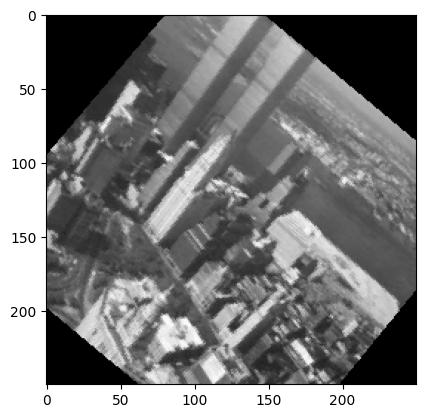

In [33]:
x = custom_warpPerspective(newyork_a, best_H, newyork_a.shape)
plt.imshow(x, cmap="gray")
plt.show()